In [1]:
%matplotlib inline
import cmlreaders as cml
from cmlreaders import CMLReader, get_data_index
import matplotlib.pyplot as plt 
import matplotlib as mp
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

import scipy 
from scipy import stats 

import pandas as pd 
import numpy as np
import os 
import sys

import pybeh_pd as pb
import pybeh_pd_min as pb_min
import seaborn as sns
import importlib

from brokenaxes import brokenaxes
import seaborn as sns

In [2]:
# Loftus-Masson (1994) adjustment for between-subject variability.
def loftus_masson(df, sub_cols, cond_col, value_col, within_cols=[]):
    if not isinstance(sub_cols, list):
        sub_cols = [sub_cols]
    if not isinstance(within_cols, list):
        within_cols = [within_cols]
    df = df.copy()
    if len(within_cols) > 0:
        df['M'] = df.groupby(within_cols)[value_col].transform('mean')
    else:
        df['M'] = df[value_col].mean()
    df['M_S'] = df.groupby(sub_cols + within_cols)[value_col].transform('mean')
    df['adj_' + value_col] = (df[value_col] + df['M'] - df['M_S'])
    return df

In [3]:
exp1_data = pd.read_csv('dataframes/KateEtal22_filter_exp1_ffr_evs.csv')

# Semantic CRP

## Overall effect

In [4]:
sem_sim_num_df = pd.read_csv('dataframes/exp1_sem_sim_num_df.csv')

In [5]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', 
                          values='similarity', dropna=False)

In [6]:
#removing doughnut because there's no vector
exp1_sem = exp1_data.query('not (item_name == "DOUGHNUT" and type == "WORD")')

In [7]:
exp1_sem = exp1_sem.query('session>=5')

In [8]:
pb_sem_crp = exp1_sem.groupby(['subject', 'session']).apply(
    pb.pd_sem_crp, list_index=['subject', 'session'], rec_type='FFR_REC_WORD',
    itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

In [9]:
pb_sem_crp_sub = pb_sem_crp.groupby(['subject','sem_bin']).agg({'prob':np.nanmean, 'sem_bin_mean':np.nanmean}).reset_index()

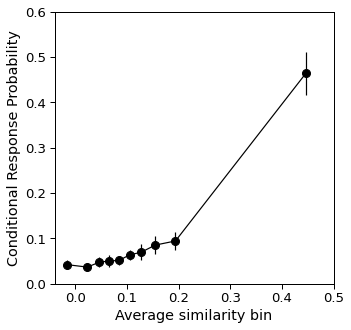

In [10]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5, 
                       ):
    fig = plt.figure(figsize=(5, 5))
    x = pb_sem_crp_sub.groupby('sem_bin').agg({'sem_bin_mean':np.nanmean})['sem_bin_mean']
    y = pb_sem_crp_sub.groupby('sem_bin').agg(mean_sem=('prob', 'mean'))['mean_sem'].to_numpy()
    std = pb_sem_crp_sub.groupby('sem_bin').agg(std=('prob', std_ddof))['std'].to_numpy()
    count = pb_sem_crp_sub.groupby('sem_bin').agg(count=('subject', 'nunique'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))
    
    plt.errorbar(x, y, yerr = yerr, color='k', marker='o', markersize=8)
    plt.xlabel('Average similarity bin')
    plt.ylabel('Conditional Response Probability')
    plt.ylim(0,0.6)
    plt.xlim(-.04, 0.5)
    
    plt.savefig('figures/exp1_semcrp.pdf')

## Change in effect across sessions

In [11]:
exp1_dist_fact = exp1_sem.groupby(['subject', 'session']).apply(
    pb.pd_dist_fact, list_index=['subject', 'session'], rec_type='FFR_REC_WORD',
    itemno_column='item_num_new', dist_mat=sem_sims, is_similarity=True).reset_index().rename(columns={0:'prob'})

In [12]:
exp1_dist_fact.to_csv('dataframes/exp1_sem.csv', index=False)

In [13]:
loftus_masson_sem=loftus_masson(exp1_dist_fact, 'subject', 'session', 'prob')

# Lag-CRP 

## Overall effect

In [14]:
# the most recent encoding phase occurs prior to retrieval - adjusting for this to run script. 
word_evs = exp1_data.query('type == "WORD"')
ffr_rec_evs = exp1_data.query('session >= 5 and type == "FFR_REC_WORD"')
word_evs['session'] = word_evs['session'] + 1
word_evs = word_evs[word_evs['session']<10]
ffr_evs = pd.concat([word_evs, ffr_rec_evs])

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
pb_lag_crp = ffr_evs.groupby(['subject','session']).apply(pb.pd_crp, list_index=['subject', 'session'], rec_type='FFR_REC_WORD',
                                itemno_column='item_num_new', lag_num=10).reset_index()

In [16]:
pb_lag_crp_sub = pb_lag_crp.groupby(['subject','lag']).agg({'prob':'mean'}).reset_index()

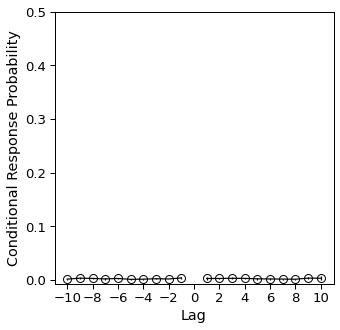

In [17]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5, 5))
    x = np.arange(-10,11,dtype=int)
    y = pb_lag_crp_sub.groupby('lag').agg({'prob':'mean'})['prob'].to_numpy()
    std = pb_lag_crp_sub.groupby('lag').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = pb_lag_crp_sub.groupby('lag').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))

    plt.errorbar(x, y, yerr=yerr, color='k', marker='o', markersize=8, fillstyle='none');
    plt.ylim(-0.007,0.50)
    plt.xlabel('Lag')
    plt.ylabel('Conditional Response Probability')
    plt.xticks(np.arange(-10,11,2))
    plt.savefig('figures/exp1_temp.pdf')

## Change in effect across sessions

In [18]:
exp1_temp_fact = ffr_evs.groupby(['subject', 'session']).apply(
    pb.pd_temp_fact, list_index=['subject', 'session'], pres_type="WORD", rec_type='FFR_REC_WORD',
    itemno_column='item_num_new').reset_index().rename(columns={0:'prob'})

In [19]:
exp1_temp_fact = exp1_temp_fact.dropna(axis='rows')

In [20]:
exp1_temp_fact.to_csv('dataframes/exp1_temp.csv', index=False)

In [21]:
loftus_masson_temp=loftus_masson(exp1_temp_fact, 'subject', 'session', 'prob')

## plotting change in semantic and temporal clustering effects on the same graph

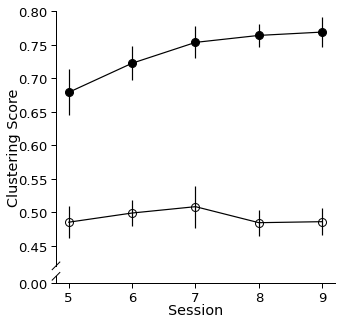

In [22]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5, 
#                           rc={'axes.labelsize': 100}
                         ):
    fig = plt.figure(figsize=(5, 5))
    bax = brokenaxes(ylims=((0, 0.01), (0.42
                                        , 0.80)), hspace=.08)
    x = np.arange(5,10,dtype=int)    
    y_sem = loftus_masson_sem.groupby('session').agg(sem_prob=('adj_prob','mean'))['sem_prob'].to_numpy()
    std_sem = loftus_masson_sem.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count_sem = loftus_masson_sem.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()
    yerr_sem = 1.96 * (std_sem / (count_sem ** 0.5))
    bax.errorbar(x, y_sem, yerr = yerr_sem, color='k', marker='o', markersize=8, label='Semantic')
    
    y_temp = loftus_masson_temp.groupby('session').agg(sem_prob=('adj_prob','mean'))['sem_prob'].to_numpy()
    std_temp = loftus_masson_temp.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count_temp = loftus_masson_temp.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()
    yerr_temp = 1.96 * (std_temp / (count_temp ** 0.5))
    bax.errorbar(x, y_temp, yerr = yerr_temp, color='k', marker='o', markersize=8, fillstyle='none', label='Temporal')
    
    

    #bax.legend(loc=3)
    
    bax.set_xticks(np.arange(5,10,1,dtype=int))
    bax.set_xlabel('Session')
    bax.set_ylabel('Clustering Score')
    plt.savefig('figures/exp1_temp_and_sem.pdf')

# Subjective CRP

## Overall effect

In [23]:
subj_evs = exp1_data.query('type == "FFR_REC_WORD"')

In [24]:
# give item numbers to recalled items that will serve as presetation items
item_col = 'item_name'
item_num_col = 'ffr_item_num'
item_num_df = subj_evs.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
subj_evs = subj_evs.merge(item_num_df, how='left')

In [25]:
ffr_pres_evs = subj_evs.copy()
ffr_pres_evs['type'] = "FFR_WORD"
ffr_pres_evs['session'] = ffr_pres_evs['session'] + 1
ffr_pres_evs = ffr_pres_evs.query('session!=10')

In [26]:
num_recs = ffr_pres_evs.groupby(['subject','session']).agg(num_recs=('item_name','count')).reset_index()

In [27]:
ffr_pres_evs_overall = ffr_pres_evs.merge(num_recs, on=['subject','session'], how='left')

In [28]:
# only keep sessions with more than 10 recalls serving as presentation events
ffr_pres_evs_overall = ffr_pres_evs_overall[ffr_pres_evs_overall['num_recs']>10]

In [29]:
# sessions 1-4 have no free recall task, so no presenation evs for session 5
ffr_rec_evs = subj_evs.query('session != 5') 

In [30]:
ffr_subj_org_evs_overall = pd.concat([ffr_pres_evs_overall, ffr_rec_evs])

In [31]:
pb_min_crp = ffr_subj_org_evs_overall.groupby(['subject', 'session']).apply(pb_min.pd_min_crp_subj, lag_num=10,list_index=['subject', 'session'],
                                                   pres_type='FFR_WORD',
                                          rec_type='FFR_REC_WORD', 
                                          itemno_column='ffr_item_num', 
                                           max_n_reps=4).reset_index()

In [32]:
pb_min_crp = pb_min_crp.groupby(['subject', 'lag']).agg({'prob':'mean'}).reset_index()

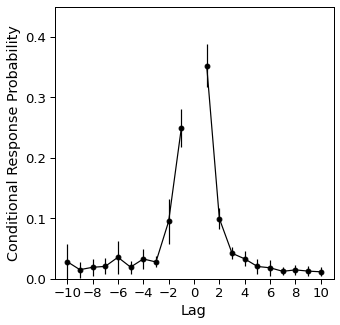

In [33]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5, 5))
    x = np.arange(-10,11,dtype=int)
    y = pb_min_crp.groupby('lag').agg({'prob':'mean'})['prob'].to_numpy()
    std = pb_min_crp.groupby('lag').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = pb_min_crp.groupby('lag').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))

    plt.errorbar(x, y, yerr=yerr, color='k', marker='o');
    plt.ylim(0,0.45)
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xlabel('Lag')
    plt.ylabel('Conditional Response Probability')
    plt.xticks(np.arange(-10,11,2))
    plt.savefig('figures/exp1_subj.pdf')

## Change in the effect across sessions

In [34]:
ffr_subj_org_evs = pd.concat([ffr_pres_evs, ffr_rec_evs])

In [35]:
exp1_subj_fact = ffr_subj_org_evs.groupby(['subject', 'session']).apply(
    pb.pd_min_temp_fact, pres_type="FFR_WORD", rec_type='FFR_REC_WORD', list_index=['subject', 'session'],
    itemno_column='ffr_item_num', max_n_reps=4).to_frame('prob').reset_index()

In [36]:
exp1_subj_fact = exp1_subj_fact.dropna(axis='rows')

In [37]:
exp1_subj_fact.to_csv('dataframes/exp1_subj.csv', index=False)

In [38]:
loftus_masson_subj=loftus_masson(exp1_subj_fact, 'subject', 'session', 'prob')

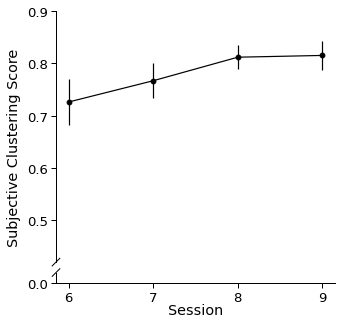

In [39]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5, 
#                           rc={'axes.labelsize': 100}
                         ):
    fig = plt.figure(figsize=(5, 5))
    bax = brokenaxes(ylims=((0, 0.02), (0.42, 0.9)), hspace=.08)
    x = np.arange(6,10,dtype=int)
    y = loftus_masson_subj.groupby('session').agg(subj_prob=('adj_prob','mean'))['subj_prob'].to_numpy()
    std = loftus_masson_subj.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count = loftus_masson_subj.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()

    yerr = 1.96 * (std / (count ** 0.5))
    bax.errorbar(x,y, yerr = yerr, color='k', marker='o' )
    #bax.errorbar(x,y, yerr = yerr, color='k', marker='o' )
    #bax.ylim(0,0.40)
    bax.set_xticks(np.arange(6,10,1,dtype=int))
    bax.set_xlabel('Session')
    bax.set_ylabel('Subjective Clustering Score')
    plt.savefig('figures/exp1_subjtrend.pdf')

# Intrusion analysis

In [40]:
exp1_data = pd.read_csv('dataframes/KateEtal22_filter_exp1_ffr_evs.csv')

In [41]:
exp1_ffr = exp1_data[(exp1_data['type']=='FFR_REC_WORD') & (exp1_data['session']>= 5)]

In [42]:
# get intrusion events, drop within session repetitions
intrusion_evs = exp1_ffr.query('intrusion==1').drop_duplicates(subset=['subject', 'session', 'item_name'])

In [43]:
# add a column that counts the number of reps for each intrusion across a subject's sessions
intrusion_evs['rep_number'] = intrusion_evs.groupby(['subject','item_name']).cumcount()


In [44]:
reps_per_sub = intrusion_evs[['subject', 'item_name', 'rep_number']]

In [45]:
# only keep the first two occurences of each intrusion
intrusion_evs = intrusion_evs[intrusion_evs['rep_number']<=1]

In [46]:
intrusion_evs.rename(columns={'item_name':'intrusion_name'}, inplace=True)

In [47]:
intrusion_evs = intrusion_evs[['subject','session','intrusion_name','rep_number']]

In [48]:
# dataframe gives the intersession lag for each intrusion
df_lags = intrusion_evs.groupby(['subject','intrusion_name']).agg(lag=('session',np.diff)).reset_index()

In [49]:
# merge intrusion events and their corresponding intersession lag
merge_intr_and_lag = intrusion_evs.merge(df_lags, on=['subject','intrusion_name'])[['subject','session','intrusion_name','lag','rep_number']]

In [50]:
# remove the second occurence of the intrusion from the intrusion events DF (we no longer needed since lags are already computed)
intr_no_within_subj_rep = intrusion_evs.drop_duplicates(subset=['subject', 'intrusion_name'])

In [51]:
# DF with the number of new intrusions per session
intr_count_df = intr_no_within_subj_rep.groupby(['subject','session']).agg(intr_count = ('intrusion_name','count')).reset_index()

In [52]:
# get a DF with the list of sessions per subject
session_df = exp1_ffr.groupby(['subject','session']).agg({'item_name':'count'}).reset_index()[['subject','session']]

In [53]:
# DF with the sessions and intrusions of each subject (to include sessions that have 0 intrusions, which will have an intr count of NaN here)
intr_and_sess_df = session_df.merge(intr_count_df, on=['subject','session'], how='left')

In [54]:
lst_of_sess = []
lst_of_intr_num = []
subjects = []

for l, li in intr_and_sess_df.groupby(['subject']):
    lst_of_sess.append(li['session'].tolist())
    lst_of_intr_num.append(li['intr_count'].tolist())
    subjects.append(l)

In [55]:
poss_lags = np.zeros((len(subjects), 4))
sub_counter = 0
for sess_lst, intr_num_lst in zip(lst_of_sess, lst_of_intr_num):
    # print('sess_lst:', sess_lst)
    # print('intr_num_lst:',intr_num_lst)
    
    poss_lags_sub = np.zeros(4)
    
    for sess, intr in zip(sess_lst, intr_num_lst):
        if sess != 9 and ~np.isnan(intr):
            poss_lags_sub[:9-sess]+=intr
            
    poss_lags[sub_counter,:]+=poss_lags_sub
    sub_counter+=1

In [56]:
new_df_lags = df_lags[df_lags['lag']!=int]

In [57]:
# DF with the number of intrusions per lag, within subject
actual_count_df = new_df_lags.groupby(['subject','lag']).agg(actual_lag_count=('intrusion_name','count')).reset_index()

In [58]:
# DF with the number of possible repetitions across sessions per lag, within subject
poss_count_df = pd.DataFrame(poss_lags)
poss_count_df['subject'] = pd.Series(subjects)
poss_count_df = poss_count_df.rename(columns={0:1, 1:2, 2:3, 3:4})
poss_count_df = poss_count_df.melt(id_vars='subject', value_vars=[1, 2, 3, 4], value_name='poss_lag_count', var_name='lag')

In [59]:
intr_lag_df = actual_count_df.merge(poss_count_df, on=['subject','lag'], how = 'right')

In [60]:
intr_lag_df = intr_lag_df.fillna(0)

In [61]:
intr_lag_df['prob'] = intr_lag_df['actual_lag_count'] / intr_lag_df['poss_lag_count']

In [62]:
intr_lag_df.to_csv('dataframes/exp1_intr_analysis_data.csv', index=False)

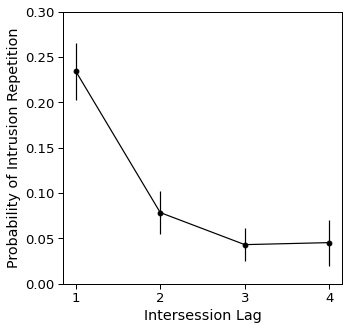

In [63]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5,5))
    x = np.arange(1,5,1,dtype=int)
    y = intr_lag_df.groupby('lag').agg({'prob':'mean'})['prob'].to_numpy()
    std = intr_lag_df.groupby('lag').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = intr_lag_df.groupby('lag').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))
    
    plt.errorbar(x, y, yerr=yerr, color='k', marker='o')
    plt.xticks(np.arange(1,5,1,dtype=int))
    plt.ylim(0,0.30)
    plt.xlabel('Intersession Lag')
    plt.ylabel('Probability of Intrusion Repetition')
    plt.savefig('figures/exp1_intrusion.pdf')

